In [1]:
import numpy as np
from numpy.linalg import*
import matplotlib.pyplot as plt
from numpy import r_, exp, cos, sin, pi, zeros, ones, hanning, sqrt, log, floor, reshape, mean
from scipy import signal
from numpy.fft import fft
import math
#%matplotlib inline

In [69]:
# Input excitation Definition (all times are in ns)
t_d = 1.0
t_r = 1.0
t_w = 20.0
t_f = 1.0
V_max = 1.0
Ex = [1.0, -1.0]

# TL info
N = 2  # Number of transmission lines
TL_Length = 14 * 0.0254  # [meter] :inch to meter converted.


# LC matrix
L = np.matrix([[418, 150], [150, 418]])
C = np.matrix([[0.118, -0.022], [-0.022, 0.118]])
LC = np.matmul(L,C)
CL = np.matmul(C,L)

L_inv = np.linalg.inv(L)
C_inv = np.linalg.inv(C)


# Eigenvectors and Eigenvalues
v_inv, E = np.linalg.eig(LC)
v_inv, H = np.linalg.eig(CL)

E_inv = np.linalg.inv(E)
H_inv = np.linalg.inv(H)

Am = np.sqrt(E@LC@E_inv)
Am_inv = np.linalg.inv(Am)

Z_C=E_inv @ Am_inv @ E @ L
Z_C_inv=np.linalg.inv(Z_C)

Z_even = np.sqrt((L[0,0]+L[0,1])/(C[0,0]+C[0,1]))
Z_odd = np.sqrt((L[0,0]-L[0,1])/(C[0,0]-C[0,1]))

Z_S = np.matrix([[50,0],[0,50]])
#Z_L = np.matrix([[Z_even,2*Z_even*Z_odd/(Z_even-Z_odd)],[2*Z_even*Z_odd/(Z_even-Z_odd),Z_even]])

Z_L = np.matrix([[1/(Z_C_inv[0,0]+Z_C_inv[0,1]), -1/Z_C_inv[0,1]],[-1/Z_C_inv[0,1],1/(Z_C_inv[0,0]+Z_C_inv[0,1])]])

Gamma_S = -np.linalg.inv(np.identity(N)+E@Z_S@L_inv@E_inv@Am)@(np.identity(N)-E@Z_S@L_inv@E_inv@Am)
Gamma_L = -np.linalg.inv(np.identity(N)+E@Z_L@L_inv@E_inv@Am)@(np.identity(N)-E@Z_L@L_inv@E_inv@Am)
Tr1 = np.linalg.inv(np.identity(N)+E@Z_S@L_inv@E_inv@Am)
Tr2 = np.linalg.inv(np.identity(N)+E@Z_L@L_inv@E_inv@Am)




In [70]:
def Waveform(t,a,rise,fall,width):
    b = a+rise
    c = b + width
    d = c + fall
    p = t
    if p<a:
        att = 0
    elif p<b:
        att = (p-a)/(b-a)
    elif p<c:
        att=1
    elif p<d:
        att = (p-d)/(c-d)
    else:
        att = 0
    return att

def Memory(t,h,a,e,l,n):
    r = np.zeros(n)
    for row in range(n):
        dely = e[row,row]*l
        argm = t-dely
        if argm < 0:
            r[row] = 0.0;
        else:
            argu = int(np.ceil(argm/h))
            r[row] = a[row, argu]
    return r

In [71]:
# Testbench
Sample = 5000 # Number of time samples
t_max = 100.0 # max simulation time in nanoseconds
dt = t_max/Sample
V_near = np.zeros(N)
V_end = np.zeros(N)
a1_h = np.zeros((N,Sample))
a2_h = np.zeros((N,Sample))
v_near1=np.zeros(Sample)
v_near2=np.zeros(Sample)
v_end1=np.zeros(Sample)
v_end2=np.zeros(Sample)
time = np.zeros(Sample)

for c in range(Sample):
    t = c*dt
    time[c]=t
    for i in range(N):
        zet = Waveform(t, t_d, t_r, t_f, t_w)
        V_near[i] = zet*Ex[i]
        V_end[i] = 0
        a1_h[i,0]=0.0
        a2_h[i,0]=0.0
    g1 = E@V_near.T
    g2 = E@V_end.T
   
    
    b1 = Memory(t, dt, a2_h, Am, TL_Length, N).T
    b2 = Memory(t, dt, a1_h, Am, TL_Length, N).T
    
    a1 = Tr1@g1.T + (Gamma_S@b1).T
    a2 = Tr2@g2.T + (Gamma_L@b2).T
    V_m1 = a1 + b1.reshape(N,1)
    V_m2 = a2 + b2.reshape(N,1)
    V1 = E_inv@V_m1
    V2 = E_inv@V_m2
    
    v_near1[c]=V1[0]
    v_near2[c]=V1[1]
    v_end1[c]=V2[0]
    v_end2[c]=V2[1]
    
    for j in range(N):
        a1_h[j,c]=a1[j]
        a2_h[j,c]=a2[j]
    


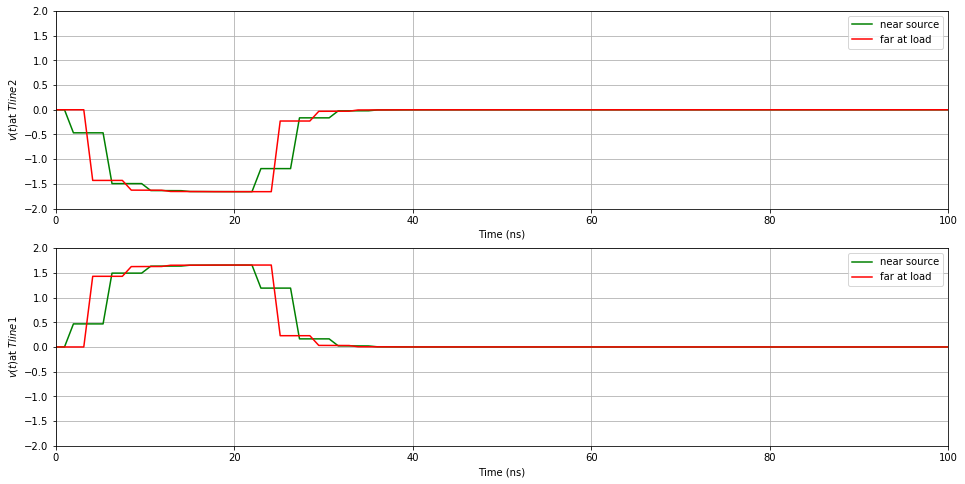

In [72]:
fig = plt.figure(figsize = (16,8))
plt.subplot(211)
plt.plot(time,v_near2, 'g', label='near source')
plt.plot(time,v_end2, 'r', label='far at load')
plt.xlabel(r'Time (ns)')
plt.ylabel(r'$v(t) $at $Tline 2$')
plt.axis((0,100,-2,2))
plt.grid()
plt.legend()

plt.subplot(212)
plt.plot(time,v_near1, 'g', label='near source')
plt.plot(time,v_end1, 'r', label='far at load')
plt.xlabel(r'Time (ns)')
plt.ylabel(r'$v(t) $at $Tline 1$')
plt.axis((0,100,-2,2))
plt.grid()
plt.legend()
